In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import scipy.stats as sst
%matplotlib inline
pd.options.display.max_rows = 500
pd.options.display.max_columns = 400
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Key functions for calculating ECI/PCI and Fitness/Complexity

In [3]:
# Calculate Economic Complexity Index

def calc_eci(M):
    """
    Calculates Economic Complexity Index based on M matrix

    Returns
    -------
    ECI vector
    """        
    Mcp = M
    num_countries = len(Mcp[:,0]) #number of countries
    num_products = len(Mcp[0,:])  #number of products

    diversity = Mcp.sum(axis = 1)
    ubiquity = Mcp.sum(axis = 0)

    inv_ubiquity = np.nan_to_num(np.true_divide(1,ubiquity)) #nan to num because some products are not exported by any countries in a given year  
    
    invU = np.diag(inv_ubiquity)
    invD = np.linalg.inv(np.diag(diversity))
    invD_M = np.matmul(invD, Mcp)
    invU_Mt = np.matmul(invU, Mcp.transpose())
    Mtilde = np.matmul(invD_M, invU_Mt)
        
    
    #calculate eigenvalues and eigenvectors of Mtilde
    e_values, e_vectors = np.linalg.eig(Mtilde)

    #sort to make sure e_values go from highest to lowest
    idx = e_values.argsort()[::-1]     #returns indexes that would sort an array, and then reverse order [start:stop:step]
    e_values = e_values[idx]
    e_vectors = e_vectors[:,idx]

    #get the eigenvector associated with the second largest eigenvalue(if this is complex, take the real part)
    K_eci = np.real(e_vectors[:,1])

    #standardize ECI so mean is zero and std is 1
    ECI = (K_eci -np.mean(K_eci))/float(np.std(K_eci))

    #determine the sign of the ECI
    corr, p = sst.pearsonr(ECI,diversity)
    if corr < 0:
        ECI = ECI*-1
        
    # here we are returning the unstandarized version for simplicity
    corr, p = sst.pearsonr(K_eci,diversity)
    if corr < 0:
        K_eci = K_eci*-1        
    
    
    return K_eci

# Calculate Product Complexity Index

def calc_pci(M):
    
    """
    Calculates Product Complexity Index based on M matrix

    Returns
    -------
    PCI vector
    """  
    
    Mcp=M.transpose()
    num_countries = len(Mcp[0,:]) #number of countries
    num_products = len(Mcp[:,0])  #number of products

    diversity = Mcp.sum(axis = 0)
    ubiquity = Mcp.sum(axis = 1)
    inv_diversity = np.nan_to_num(np.true_divide(1,diversity)) 
    
    #calculate Mtilde matrix 

    invU = np.linalg.inv(np.diag(ubiquity))
    invD = np.diag(inv_diversity)
    invD_M = np.matmul(invD, Mcp.transpose())
    invU_Mt = np.matmul(invU, Mcp)
    Mtilde = np.matmul(invU_Mt, invD_M)
                
    # Calculate eigenvalues and eigenvectors of Mtilde
    e_values, e_vectors = np.linalg.eig(Mtilde)

    # Sort to make sure e_values go from highest to lowest
    idx = e_values.argsort()[::-1]     
    e_values = e_values[idx]
    e_vectors = e_vectors[:,idx]

    # Get the eigenvector associated with the second largest eigenvalue      
    K_pci = np.real(e_vectors[:,1])

    # Standardize PCI so mean is zero and std is 1
    PCI = (K_pci -np.mean(K_pci))/float(np.std(K_pci))

    #determine the sign of the PCI. 
    
#     corr, p = sst.pearsonr(PCI,ubiquity)
#     if corr > 0:
#         PCI = PCI*-1    
    
    corr, p = sst.pearsonr(K_pci,ubiquity)
    if corr > 0:
        K_pci = K_pci*-1  
      
    return K_pci

def calc_Fitness_complexity(M):
    
    """
    Calculates Fitness and Complexity metrics based on M matrix

    Returns
    -------
    Fitness and Complexity vectors
    """  
    data = M
    
    num_products = len(data[0,:])
    num_countries = len(data[:,0])

    Fitness = np.ones((num_countries)) #Initial value of fitness vector is equal to 1
    Complexity = np.ones((num_products)) #Initial value of the complexity vector is equal to 1

    Max_iterations = 500 #Maximum number of iteratiosn for convergence 
    Error = 0.005 #Variation of the fitness or complexity between two timestep for convergence
    stop = 0 #stop = 1 if the algorithm has converged or if number iterations has reached max iteraitons

    Fitness_temp = np.zeros((num_countries))
    Complexity_temp = np.zeros((num_products))
    inverse_fitness = np.zeros((num_countries))
    inverse_fitness2 = np.zeros((num_products))
    Max_error = 1
    step = 0

    while stop == 0:
        Fitness_temp = Fitness
        Complexity_temp = Complexity
        for i in range(num_countries):
            inverse_fitness[i] = 1/float(Fitness[i])

        Fitness = np.sum(data*Complexity_temp,axis = 1)
        Fitness = Fitness/float(np.mean(Fitness))

        intermediate = np.sum(data.transpose()*inverse_fitness,axis = 1)
        for i, c in enumerate(intermediate):
            inverse_fitness2[i] = 1/float(c)
        Complexity = inverse_fitness2
        Complexity = Complexity/float(np.mean(Complexity))

        #compute the error
        Error_fitness = np.abs(np.divide ( (Fitness-Fitness_temp), Fitness ))
        Error_complexity = np.abs( np.divide( (Complexity - Complexity_temp), Complexity))

        Max_error = max([max(Error_complexity),max(Error_fitness)])
        if Max_error < Error or step > Max_iterations:
            stop = 1

        step += 1   

    return Fitness, Complexity
                              
    

### Calculate measures for sorting rows and columns of the country policy (M) matrix


In [4]:
## Read in M matrix
M = np.loadtxt('github_intermediate/M_Nci_matrix.csv', delimiter = ',')
M_df = pd.read_csv('github_intermediate/M_Nci_df.csv',index_col=[0])

# Calculate country policy diversity and policy prevalence across countries
diversity = np.sum(M,axis = 1)
prevalence = np.sum(M,axis = 0)

# Calculate ECI and PCI
ECI = calc_eci(M)
PCI = calc_pci(M)

# Calculate Fitness and Complexity
Fitness, Complexity = calc_Fitness_complexity(M)

# Munge results into dataframes
country_df = pd.DataFrame()
country_df['countries']=M_df.index
country_df['diversity']=diversity
country_df['Fitness']=Fitness
country_df['ECI']=ECI


policy_df = pd.DataFrame()
policy_df['policies']=M_df.columns
policy_df['prevalence']=prevalence
policy_df['Complexity']=Complexity*-1
policy_df['PCI']=PCI*-1

country_df_ranks = country_df.copy()
country_df_ranks['diversity_rank']=country_df_ranks['diversity'].rank(ascending = False)
country_df_ranks['Fitness_rank']=country_df_ranks['Fitness'].rank(ascending = False)
country_df_ranks['ECI_rank']=country_df_ranks['ECI'].rank(ascending = False)
country_df_ranks = country_df_ranks.sort_values('diversity_rank')

policy_df_ranks =policy_df.copy()
policy_df_ranks['prevalence_rank']=policy_df_ranks['prevalence'].rank(ascending = False)
policy_df_ranks['Complexity_rank']=policy_df_ranks['Complexity'].rank(ascending = False)
policy_df_ranks['PCI_rank']=policy_df_ranks['PCI'].rank(ascending = False)
policy_df_ranks=policy_df_ranks.sort_values('prevalence_rank')

## Output country and policy values and rank tables
country_df.to_csv('github_outputs/nestedness_country_values_table.csv',index = False)
policy_df.to_csv('github_outputs/nestedness_policy_values_table.csv',index = False)

country_df_ranks.to_csv('github_outputs/nestedness_country_rank_table.csv',index = False)
policy_df_ranks.to_csv('github_outputs/nestedness_policy_rank_table.csv',index = False)



### Correlation tables


In [45]:
# Correlation table for country ranks

country_df_ranks[['diversity_rank','Fitness_rank','ECI_rank']].corr()

,diversity_rank,Fitness_rank,ECI_rank
diversity_rank,1.000000,0.949712,0.846483
Fitness_rank,0.949712,1.000000,0.928112
ECI_rank,0.846483,0.928112,1.000000


In [46]:
# Correlation table for policy ranks

policy_df_ranks[['prevalence_rank','Complexity_rank','PCI_rank']].corr()

,prevalence_rank,Complexity_rank,PCI_rank
prevalence_rank,1.000000,0.852675,0.694193
Complexity_rank,0.852675,1.000000,0.922394
PCI_rank,0.694193,0.922394,1.000000


### Nestedness figure and NODF value

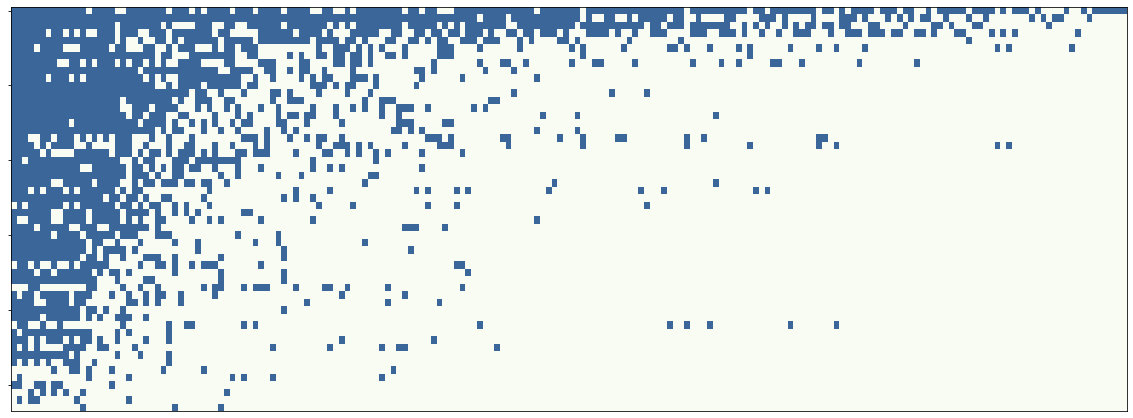

In [5]:
# Create nestedness figure

countries = list(M_df.index)
pols =  list(M_df.columns)

table = M.transpose()
idx = diversity.argsort()[::-1] #replace diversity with ECI or Fitness to sort by other variables
temp = np.take(table, idx, axis = 1)

idy = prevalence.argsort()[::-1] #replace prevalence with PCI or Complexity to sort by other variables
sorted_table_div_ubi = np.take(temp, idy, axis = 0)
fig,ax = plt.subplots(figsize = (20,16))
ax.imshow(sorted_table_div_ubi, cmap = 'GnBu', interpolation = 'nearest', aspect = 1.3, alpha = 0.8)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


plt.savefig('github_outputs/nestedness_plot_degree.jpg',bbox_inches = 'tight', dpi = 300)
#plt.show()

In [48]:
# Calculate nestedness values based on NODF code by Straka, 2017 https://github.com/tsakim/nestedness

import sys
sys.path.insert(0,'nestedness-master/')
import nestedness_calculator

from nestedness_calculator import NestednessCalculator

nodf_score = NestednessCalculator(sorted_check_div_ubi).nodf(sorted_check_div_ubi)
# sorting by diversity and prevalence
nodf_score

0.6437807120232291